# ШАГ 1

Поставлена задача: определить какой тариф прибыльнее для компании.

В распоряжении у нас есть несколько файлов - баз данных по 500 пользователям за 2018 год. 

Загрузим эти файлы в оперативную память.

Имтортируем необходимые библиотеки

In [141]:
import pandas as pd
import numpy as np
import math as mt
from matplotlib import pyplot as plt
from scipy import stats as st

Загрузим данные

In [102]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

Все данные успешно загрузились. Просмотрим содержимое файла `calls.csv`

In [103]:
df_calls.info()
display(df_calls.head())
df_calls.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

Файл содержит 202607 строк и 4 столбца: id, дату, продолжительность, идентификатор пользователя. 

Данные не содержат пропусков. Названия столбцов корректны.

Данные столбца `call_date` изменим на формат datetime для удобства

Продолжительность разговора округлим до целых минут в большую сторону (Мегалайн всегда округляет секунды до минут)

In [104]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls['duration'] = df_calls['duration'].apply(mt.ceil)

Просмотрим содержимое файла `internet.csv`


In [105]:
df_internet.info()
display(df_internet.head())
df_internet.columns

# Ищем нули
df_internet.describe()
print(df_internet.query('mb_used == 0').count())
display(df_internet.query('mb_used == 0').head(10))
# посмотрим каким тарифом пользовались пользователи с нулями в столбце mb_used
df_merge = df_internet.query('mb_used == 0').merge(df_users, on='user_id')
print('Количество пользователей с 0 интернет-траффиком и тарифом "ULTRA" - {} или {:.0%}'
      .format(df_merge.query('tariff == "ultra"')['tariff'].count(), df_merge.query('tariff == "ultra"')['tariff'].count()/len(df_merge)))
print('Количество пользователей с 0 интернет-траффиком и тарифом "SMART" - {} или {:.0%}'
      .format(df_merge.query('tariff == "smart"')['tariff'].count(), df_merge.query('tariff == "smart"')['tariff'].count()/len(df_merge)))



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Unnamed: 0      19598
id              19598
mb_used         19598
session_date    19598
user_id         19598
dtype: int64


,Unnamed: 0,id,mb_used,session_date,user_id
11,11,1000_11,0.0,2018-08-28,1000
38,38,1000_38,0.0,2018-11-27,1000
46,46,1000_46,0.0,2018-06-30,1000
67,67,1000_67,0.0,2018-06-16,1000
72,72,1000_72,0.0,2018-06-15,1000
103,103,1000_103,0.0,2018-05-26,1000
111,111,1000_111,0.0,2018-09-01,1000
131,131,1000_131,0.0,2018-06-15,1000
143,143,1000_143,0.0,2018-12-29,1000
157,157,1000_157,0.0,2018-07-11,1000


Количество пользователей с 0 интернет-траффиком и тарифом "ULTRA" - 1775 или 9%
Количество пользователей с 0 интернет-траффиком и тарифом "SMART" - 17823 или 91%


Файл содержит 149396 строк и 5 столбцов: 
    <li>`Unnamed`: 0 - колонка дублирует номера строк, вероятно ее нужно дропнуть, 
    <li>id (в том же формате что и в предыдущем файле), 
    <li>mb_used - использованное количество мегабайт,
    <li>session_date - дата сессии
    <li>user_id - идентификатор пользователя.
            
Убирем столбец с именем `unnamed`: 0 и изменим формат данных даты на datetime

В столбце `mb_used` есть нули в количестве 19598, при этом остальные данные целые. Вероятно пользователи не пользовались интернетом вообще или у них не было такой возможности.

Если то, как распределяются пользователи, не использующие интернет-трафик, между тарифами, то 10% - это пользователи более дорогостоящего тарифа, а 90% - `smart`.

In [106]:
df_internet = df_internet.drop('Unnamed: 0', 1)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')


Просмотрим содержимое файла `messages.csv`

In [107]:
df_messages.info()
display(df_messages.head())
df_messages.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Index(['id', 'message_date', 'user_id'], dtype='object')

Файл содержит 123036 строк, с временем и идентификатором пользователя - вероятно когда и кем было отправлено сообщение. 

Пропусков нет, названия столбцов корректные.

Заменим дату сообщений на формат datatime

In [108]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')

Просмотрим содержимое файла `tariffs.csv`


In [109]:
df_tariffs.info()
display(df_tariffs.head())
_ = [print('"{}""'.format(x)) for x in df_tariffs.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


"messages_included""
"mb_per_month_included""
"minutes_included""
"rub_monthly_fee""
"rub_per_gb""
"rub_per_message""
"rub_per_minute""
"tariff_name""


Файл содержит 2 строки - данные по двум тарифам: сколько включено сообщений, мегабайт, минут, ежемесячная оплата, дополнительная плата за ГБ, стоимость одного сообщения, минуты и название тарифа. Пропусков данных нет, названия столбцов корректные.

Просмотрим содержимое файла users.csv


In [110]:
df_users.info()
display(df_users.head())
_ = [print('"{}"'.format(x)) for x in df_users.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


"user_id"
"age"
"churn_date"
"city"
"first_name"
"last_name"
"reg_date"
"tariff"


Последний файл содержит данные 500 пользователей: user_id, возраст, дата отключения тарифа (есть пропуски, но по условию пропуск означает что тариф все еще подключен - на момент выгрузки базы данных), город, имя и фамилия, дата подключения тарифа, тариф.

In [111]:
df_users['churn_date'] = df_users['churn_date'].fillna('2018-12-31')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

## Вывод: 

Таким образом, у нас есть несколько таблиц, в которых есть смежные данные (user_id). Для дальнейшего анализа планируется соединить эти таблицы в одну.


# ШАГ 2: Подготовка данных</h1>
* В таблицах calls, messges и internet добавим столбец с номером месяца
* Возьмем за основу таблицу df_users.
* Соединим таблицу df_users c df_calls, df_messages и df_internet 
* Затем соединим получившиеся таблицы первую ко второй, вторую к третей.
* Cделаем необходимые расчеты


In [112]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month

Создадим сводную таблицу `df_calls` по `user_id` и `month`, значение `duration` агрегируем функциями *sum* (сумма минут или продолжительность разговора) и *count* (количество звонков) за соответствующий месяц

In [113]:
df_calls = df_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['sum', 'count'], fill_value=0)
df_calls.head(10)

sum    count
              duration duration
user_id month                  
1000    5          159       22
        6          172       43
        7          340       47
        8          408       52
        9          466       58
        10         350       57
        11         338       43
        12         333       46
1001    11         430       59
        12         414       63

Сделаем названия столбцом одноэтажными и обновим индекс

In [114]:
df_calls.columns = ['duration_sum', 'calls_count']
df_calls = df_calls.reset_index()
df_calls.head(10)

,user_id,month,duration_sum,calls_count
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
5,1000,10,350,57
6,1000,11,338,43
7,1000,12,333,46
8,1001,11,430,59
9,1001,12,414,63


Сделаем то же самое с таблицей `df_message`. В ней агрегируем по `id` (количество сообщений), заменим название столбца `id` на *count*.

In [115]:
df_messages = df_messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_messages = df_messages.rename(columns={'id':'count_msg'}).reset_index()

Сделаем то же самое с таблицей `df_internet`. В ней агрегируем по `mb_used` (сумма мегабайт), затем создадим новый столбец и в нем переведем значение мб в ГБ.


In [116]:
df_internet = df_internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
df_internet['gb_used'] = df_internet['mb_used'].apply(lambda x: mt.ceil(x/1024))

In [117]:
df_internet.head()

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15


Соединим таблицу df_users с таблицами: 1 - df_calls, 2 - df_messages, 3 - df_internet паралельно.

А затем через join соединим в единый df таблицы 1 с 2, затем с 3

Посмотрим на структуру получившейся таблицы через info


In [118]:
df_tmp = df_calls.merge(df_messages, on=['user_id', 'month'], how='outer')
df_tmp = df_tmp.merge(df_internet, on=['user_id', 'month'], how='outer')
df2 = df_tmp.merge(df_users, on=['user_id'], how='outer')

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3216 non-null   int64         
 1   month         3214 non-null   float64       
 2   duration_sum  3174 non-null   float64       
 3   calls_count   3174 non-null   float64       
 4   count_msg     2717 non-null   float64       
 5   mb_used       3203 non-null   float64       
 6   gb_used       3203 non-null   float64       
 7   age           3216 non-null   int64         
 8   churn_date    3216 non-null   datetime64[ns]
 9   city          3216 non-null   object        
 10  first_name    3216 non-null   object        
 11  last_name     3216 non-null   object        
 12  reg_date      3216 non-null   datetime64[ns]
 13  tariff        3216 non-null   object        
dtypes: datetime64[ns](2), float64(6), int64(2), object(4)
memory usage: 376.9+ KB


In [119]:
df2 = df2.drop(columns='mb_used')

lst = ['month', 'duration_sum', 'calls_count', 'count_msg', 'gb_used']
for x in lst:
    df2[x] = df2[x].fillna(0).astype('int')

df2 = df2.query('month != 0')
df2.info()
df2.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       3214 non-null   int64         
 1   month         3214 non-null   int64         
 2   duration_sum  3214 non-null   int64         
 3   calls_count   3214 non-null   int64         
 4   count_msg     3214 non-null   int64         
 5   gb_used       3214 non-null   int64         
 6   age           3214 non-null   int64         
 7   churn_date    3214 non-null   datetime64[ns]
 8   city          3214 non-null   object        
 9   first_name    3214 non-null   object        
 10  last_name     3214 non-null   object        
 11  reg_date      3214 non-null   datetime64[ns]
 12  tariff        3214 non-null   object        
dtypes: datetime64[ns](2), int64(7), object(4)
memory usage: 351.5+ KB


,user_id,month,duration_sum,calls_count,count_msg,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,159,22,22,3,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,172,43,60,23,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,340,47,75,14,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,408,52,81,14,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,466,58,57,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000,10,350,57,73,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000,11,338,43,58,15,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000,12,333,46,70,10,52,2018-12-31,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1001,11,430,59,0,18,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart
9,1001,12,414,63,0,14,41,2018-12-31,Москва,Иван,Ежов,2018-11-01,smart


Оставим лишь те столбцы с которыми будем работать дальше

In [120]:
df2 = df2[['user_id', 'city', 'month', 'duration_sum', 'calls_count', 'count_msg', 'gb_used', 'tariff']]
df2.info()
df2.head(50)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       3214 non-null   int64 
 1   city          3214 non-null   object
 2   month         3214 non-null   int64 
 3   duration_sum  3214 non-null   int64 
 4   calls_count   3214 non-null   int64 
 5   count_msg     3214 non-null   int64 
 6   gb_used       3214 non-null   int64 
 7   tariff        3214 non-null   object
dtypes: int64(6), object(2)
memory usage: 226.0+ KB


,user_id,city,month,duration_sum,calls_count,count_msg,gb_used,tariff
0,1000,Краснодар,5,159,22,22,3,ultra
1,1000,Краснодар,6,172,43,60,23,ultra
2,1000,Краснодар,7,340,47,75,14,ultra
3,1000,Краснодар,8,408,52,81,14,ultra
4,1000,Краснодар,9,466,58,57,15,ultra
5,1000,Краснодар,10,350,57,73,15,ultra
6,1000,Краснодар,11,338,43,58,15,ultra
7,1000,Краснодар,12,333,46,70,10,ultra
8,1001,Москва,11,430,59,0,18,smart
9,1001,Москва,12,414,63,0,14,smart


Если неизвестен месяц, то это данные не к чему присовокупить и их не так уж и много - около 1%. Исключим их из датасета.

In [121]:
df2 = df2.query('month == month')

Посмотрим какие пропуски остались

In [122]:
df2.isna().mean()

user_id         0.0
city            0.0
month           0.0
duration_sum    0.0
calls_count     0.0
count_msg       0.0
gb_used         0.0
tariff          0.0
dtype: float64

Остались пропуски в столбце `count_msg` 15% и `gb_used` менее 1%. Если данных в этих ячейках нет, вероятнее всего их и не было. Заполним их нулями.


In [123]:
df2['count_msg'] = df2['count_msg'].fillna(0)
df2['gb_used'] = df2['gb_used'].fillna(0)

Для того, чтобы определить помесячную вырочку для каждого пользователя, создадим в датасете новый параметр - `profit`. Также создадим функцию, которая заполнит ячейки в этом параметре (используем функцию одной строки). Данные по тарифам возьмем из `df_tariff`.


In [124]:
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
df2 = df2.merge(df_tariffs, on='tariff').sort_values('user_id').set_index('user_id')
df2.head(20)

,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
user_id,,,,,,,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,6,172,43,60,23,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,7,340,47,75,14,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,8,408,52,81,14,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,9,466,58,57,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,10,350,57,73,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,11,338,43,58,15,ultra,1000,30720,3000,1950,150,1,1
1000,Краснодар,12,333,46,70,10,ultra,1000,30720,3000,1950,150,1,1
1001,Москва,12,414,63,0,14,smart,50,15360,500,550,200,3,3


In [125]:
def profit_f(row):
      profit_calls_duration = max(0, row['duration_sum'] - row['minutes_included']) * row['rub_per_minute']
      profit_count_msg = max(0, row['count_msg'] - row['messages_included']) * row['rub_per_message']
      profit_gb_used = max(0, (row['gb_used'] - row['mb_per_month_included']//1024)) * row['rub_per_gb']
      return profit_calls_duration + profit_count_msg + profit_gb_used + row['rub_monthly_fee']

df2['profit'] = df2.apply(profit_f, axis = 1)
df2 = df2.drop(['messages_included',
                'mb_per_month_included', 
                'minutes_included', 
                'rub_monthly_fee', 
                'rub_per_gb', 
                'rub_per_message', 
                'rub_per_minute'], axis=1) 
df2.head(15)

,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,profit
user_id,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1950
1000,Краснодар,6,172,43,60,23,ultra,1950
1000,Краснодар,7,340,47,75,14,ultra,1950
1000,Краснодар,8,408,52,81,14,ultra,1950
1000,Краснодар,9,466,58,57,15,ultra,1950
1000,Краснодар,10,350,57,73,15,ultra,1950
1000,Краснодар,11,338,43,58,15,ultra,1950
1000,Краснодар,12,333,46,70,10,ultra,1950
1001,Москва,12,414,63,0,14,smart,550


Создадим сводную таблицу `df2_pivot` в которой сведем информацию по индексам `user_id`, и колонкам `tariff`, агрегируем данные по продолжительности и количества звонков, количеству смс и инет-трафика, выведя среднее значение по всем месяцам. И выведем на экран.

In [126]:
df2_pivot = df2.pivot_table(index=['user_id'], values=['duration_sum', 'calls_count', 'count_msg', 'gb_used', 'profit'], aggfunc=('mean'))

df2_pivot.head(10)

,calls_count,count_msg,duration_sum,gb_used,profit
user_id,,,,,
1000,46.0,62.0,320.750000,13.625000,1950.000000
1001,61.0,0.0,422.000000,16.000000,850.000000
1002,31.0,10.0,216.714286,16.714286,1035.714286
1003,104.0,76.0,764.400000,11.800000,1950.000000
1004,22.0,149.0,123.375000,18.750000,1950.000000
1005,74.0,46.0,550.416667,8.583333,827.000000
1006,46.0,0.0,318.272727,15.090909,931.818182
1007,68.0,25.0,486.555556,14.888889,913.444444
1008,52.0,56.0,339.000000,13.000000,568.000000


Для упрощения восприятия заменим мультииндекс на одноэтажный


## Вывод:

Обработав данные во втором шаге мы получили сводную таблицу, где предоставлены данные по количеству и продолжительности звонков, по количеству смс и интернет тарфику. Значения данных в столбцах представлены средними значениями за месяц и в итоговой таблице среднее за все месяцы.


Из этой таблицы получены данные (Series) - выборки для двух тарифов, которые нужно сравнить, данные очищены от пропусков и приведены к целочисленному значению.

# ШАГ 3: Анализ данных

Определим сколько минут разговора, смс и интернет трафика требуется каждому пользователю тарифом в месяц


<div style="color: white; border:solid green 2px; padding: 20px; background: LightSeaGreen">
    <p> Определим объемы выборок - сколько элементов в каждой
</div>

In [127]:
print('SMART = ', len(df2.query('tariff == "smart"').reset_index()['user_id']))
print('ULTRA = ', len(df2.query('tariff == "ultra"').reset_index()['user_id']))

df2.head()

SMART =  2229
ULTRA =  985


,city,month,duration_sum,calls_count,count_msg,gb_used,tariff,profit
user_id,,,,,,,,
1000,Краснодар,5,159,22,22,3,ultra,1950
1000,Краснодар,6,172,43,60,23,ultra,1950
1000,Краснодар,7,340,47,75,14,ultra,1950
1000,Краснодар,8,408,52,81,14,ultra,1950
1000,Краснодар,9,466,58,57,15,ultra,1950


In [128]:
df2.reset_index().groupby('tariff')['user_id'].nunique()

tariff
smart    350
ultra    148
Name: user_id, dtype: int64

Люди предпочитают тариф SMART тарифу ULTRA, вероятно более низкой его стоимости



SMART - среднее количество смс = 33 шт.
SMART - среднее количество смс - дисперсия = 796.8129584480083
SMART - среднее количество смс - стандартное отклонение = 28.221542886898938

ULTRA - среднее количество смс = 49 шт.
ULTRA - среднее количество смс - дисперсия 2285.266142544674
ULTRA - среднее количество смс - стандартное отклонение = 47.78018496610161



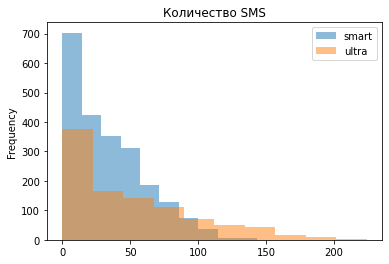

In [129]:
df2.query('tariff == "smart"')['count_msg'].plot.hist(alpha=.5, label='smart', legend=True, title='Количество SMS')
df2.query('tariff == "ultra"')['count_msg'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - среднее количество смс = {} шт.'.format(int(df2.query('tariff == "smart"')['count_msg'].mean())))
print('SMART - среднее количество смс - дисперсия = {}'.format(np.var(df2.query('tariff == "smart"')['count_msg'], ddof=1)))
print('SMART - среднее количество смс - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['count_msg'])))
print()
print('ULTRA - среднее количество смс = {} шт.'.format(int(df2.query('tariff == "ultra"')['count_msg'].mean())))
print('ULTRA - среднее количество смс - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['count_msg'], ddof=1)))
print('ULTRA - среднее количество смс - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['count_msg'])))
print()

В среднем пользователям тарифа СМАРТ требуется до 150 смс в месяц, в среднем 33, при этом они редко используют более 120 смс. 

Возможно это связано с ограничением включенных в тариф смс - 50 в месяц.

Пользователи тарифа УЛЬТРА пользуются смс-ками до 200 в месяц со средним в 49 штук в месяц. 

Дисперсии обладателей тарифов по использованию смс отличаются в 3 раза (больше дисперсия у пользователей УЛЬТРА, что говорит о большем разбросе значений, т.е. они более свободны в выборе - куда и сколько потратить смс).
        



SMART - среднее количество звонков = 58 шт.
SMART - среднее количество звонков - дисперсия 672.8762433017358
SMART - среднее количество звонков - стандартное отклонение = 25.934038823652493

ULTRA - среднее количество звонков = 73 шт.
ULTRA - среднее количество звонков - дисперсия 1928.6899900953324
ULTRA - среднее количество звонков - стандартное отклонение = 43.89455466446473



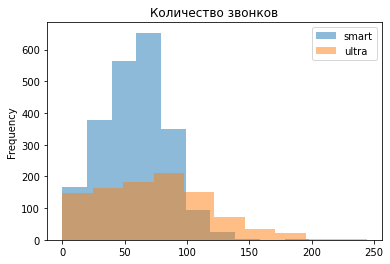

In [130]:
df2.query('tariff == "smart"')['calls_count'].plot.hist(alpha=.5, label='smart', legend=True, title='Количество звонков')
df2.query('tariff == "ultra"')['calls_count'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - среднее количество звонков = {} шт.'.format(int(df2.query('tariff == "smart"')['calls_count'].mean())))
print('SMART - среднее количество звонков - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['calls_count'], ddof=1)))
print('SMART - среднее количество звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['calls_count'])))
print()
print('ULTRA - среднее количество звонков = {} шт.'.format(int(df2.query('tariff == "ultra"')['calls_count'].mean())))
print('ULTRA - среднее количество звонков - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['calls_count'], ddof=1)))
print('ULTRA - среднее количество звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['calls_count'])))
print()

У обладателей тарифа `СМАРТ` среднее количество звонков 58 шт/мес, у обладателей `УЛЬТРА` среднее количество 73 звонка. 

Дисперсия по этому параметру больше у тарифа `УЛЬТРА` в 3 раза.



SMART - средняя продолжительность звонков = 417 мин
SMART - средняя продолжительность звонков - дисперсия 36219.31578434428
SMART - средняя продолжительность звонков - стандартное отклонение = 190.27103471651876

ULTRA - средняя продолжительность звонков = 526 мин
ULTRA - средняя продолжительность звонков - дисперсия 100873.63339730098
ULTRA - средняя продолжительность звонков - стандартное отклонение = 317.44483554974113



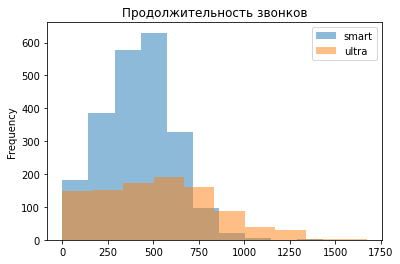

In [131]:
df2.query('tariff == "smart"')['duration_sum'].plot.hist(alpha=.5, label='smart', legend=True, title='Продолжительность звонков')
df2.query('tariff == "ultra"')['duration_sum'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - средняя продолжительность звонков = {} мин'.format(int(df2.query('tariff == "smart"')['duration_sum'].mean())))
print('SMART - средняя продолжительность звонков - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['duration_sum'], ddof=1)))
print('SMART - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['duration_sum'])))
print()
print('ULTRA - средняя продолжительность звонков = {} мин'.format(int(df2.query('tariff == "ultra"')['duration_sum'].mean())))
print('ULTRA - средняя продолжительность звонков - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['duration_sum'], ddof=1)))
print('ULTRA - средняя продолжительность звонков - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['duration_sum'])))
print()

По продолжительности звонков пользователем тарифа смарт обычно требуется от 200 до 750 минут в месяц, в среднем 417 мин (500 минут включено в тарифный план). В то же время пользователи тарифа УЛЬТРА в среднем разговаривают чуть больше  - от 0 до 1000 минут, в среднем 526 минут. Но 3000 минут (включенные минуты в тариф) никто не проговорил...

При этом дисперсия по продолжительности звонков больше у тарифа ультра - они могут позволить себе дольше говорить по телефону, поскольку у них меньше ограничений (3000 минут включенных в тарифный план).


SMART - интернет трафик = 16 Гб/мес
SMART - интернет трафик - дисперсия 33.02870517811161
SMART - интернет трафик - стандартное отклонение = 5.745771267187499

ULTRA - интернет трафик = 19 Гб/мес
ULTRA - интернет трафик - дисперсия 97.09168626965459
ULTRA - интернет трафик - стандартное отклонение = 9.848508314957495



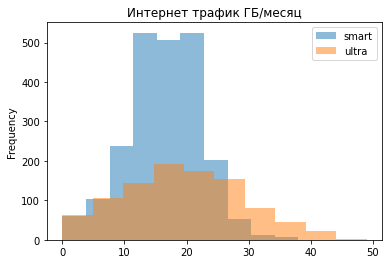

In [132]:
df2.query('tariff == "smart"')['gb_used'].plot.hist(alpha=.5, label='smart', legend=True, title='Интернет трафик ГБ/месяц')
df2.query('tariff == "ultra"')['gb_used'].plot.hist(alpha=.5, label='ultra', legend=True)
print()
print('SMART - интернет трафик = {} Гб/мес'.format(int(df2.query('tariff == "smart"')['gb_used'].mean())))
print('SMART - интернет трафик - дисперсия {}'.format(np.var(df2.query('tariff == "smart"')['gb_used'], ddof=1)))
print('SMART - интернет трафик - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "smart"')['gb_used'])))
print()
print('ULTRA - интернет трафик = {} Гб/мес'.format(int(df2.query('tariff == "ultra"')['gb_used'].mean())))
print('ULTRA - интернет трафик - дисперсия {}'.format(np.var(df2.query('tariff == "ultra"')['gb_used'], ddof=1)))
print('ULTRA - интернет трафик - стандартное отклонение = {}'.format(np.std(df2.query('tariff == "ultra"')['gb_used'])))
print()

Интернетом более активно пользуются обладатели тарифа `ULTRA` в среднем 19 Гб/мес, обладатели `SMART` - в среднем 16 в месяц. Дисперсии отличаются в 3 раза (больше у обладателей `ULTRA`).


## Вывод:

Изучив данные выборок можно прийти к выводу что пользователи двух тарифов принципиально отличаются по пользованию СМС и продолжительностью терефонных разговоров. По интернет трафику и количеству звонков нет видимых различий.

# ШАГ 4: Проверка гипотез

Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Если средняя выручка тарифов не различаются, значит они относятся к одной генеральной совокупности и их средние значения не выйдут за порог значения альфа = 0.5 (т.е. р-значение будет больше 0.5) - это нулевая гипотеза.

Произведем расчет:

In [133]:
profit_smart = df2.query('tariff == "smart"')['profit']
profit_ultra = df2.query('tariff == "ultra"')['profit']

alpha = .05
dif_profit_result = st.ttest_ind(profit_smart, profit_ultra)
print('p-значение = ', dif_profit_result.pvalue)

p-значение =  1.4229814360764067e-160


Мы имеем очень малое р-знаение (ноль!), что говорит о том, что средние выручки тарифов относятся к разным гененальным совокупностям (отвергаем нулевую гипотезу) и эти выручки значимо различаются.

Возьмем среднее значение чтобы узнать какой тариф лучше:


In [134]:
print('SMART profit mean : {}'.format(df2.query('tariff == "smart"')['profit'].mean()))
print('ULTRA profit mean : {}'.format(df2.query('tariff == "ultra"')['profit'].mean()))

SMART profit mean : 1289.9735307312696
ULTRA profit mean : 2070.1522842639592


Выборки имеют статистические различия, и среднее значение прибыли по тарифу `УЛЬТРА` выше

Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Нулевая гипотеза: Средняя выручка пользователей Москвы = среднней выручке других регионов.

Выделим 2 выборки: `df_moscow` и `df_vne_moscow`.

In [135]:
df_moscow = df2.query('city == "Москва"')
df_vne_moscow = df2.query('city != "Москва"')

In [136]:
df_moscow_pivot = df_moscow.pivot_table(index=['user_id'], values=['profit'], aggfunc=('mean'))
df_vne_moscow_pivot = df_vne_moscow.pivot_table(index=['user_id'], values=['profit'], aggfunc=('mean'))

In [137]:
dif_profit_result = st.ttest_ind(df_moscow_pivot['profit'], df_vne_moscow_pivot['profit'])
print('p-значение = ', dif_profit_result.pvalue)

p-значение =  0.36094633224451433


p-значение = 0.18 > 0.1 альфа, значит наша нулевая гипотеза не верна: средняя выручка в Москве не равна средней выручке в других регионах.
Проверим это, возьмем среднее по выборкам:


In [138]:
print('Средняя прибыль по одному клиенту по Москве: ', df_moscow_pivot['profit'].mean())
print('Средняя прибыль по одному клиенту по не Москве: ', df_vne_moscow_pivot['profit'].mean())

Средняя прибыль по одному клиенту по Москве:  1498.465851152215
Средняя прибыль по одному клиенту по не Москве:  1563.8822229636141


В Москве прибыль выше.

## Вывод



Средняя выручка пользователей тарифов "Ультра" и "Смарт" статистически различаются.

Средняя выручка пользователей из Москвы и других регионов статистически одинаковы.
    
    

# Вывод

В результате нашего исследования мы выяснили что тариф "УЛЬТРА" показал статистически значимые различия по отношение к тарифу "СМАРТ". 

Т.о. тариф "УЛЬТРА" прибыльнее тарифа "СМАРТ".

In [139]:
df2.pivot_table(index='tariff', values=['duration_sum', 'count_msg', 'gb_used'],
                       aggfunc=['mean', 'std', 'var'])

mean                                std                         \
        count_msg duration_sum    gb_used  count_msg duration_sum   gb_used   
tariff                                                                        
smart   33.384029   417.934948  16.328847  28.227876   190.313730  5.747061   
ultra   49.363452   526.623350  19.494416  47.804457   317.606098  9.853511   

                var                            
          count_msg   duration_sum    gb_used  
tariff                                         
smart    796.812958   36219.315784  33.028705  
ultra   2285.266143  100873.633397  97.091686

In [140]:
l1 = ['duration_sum', 'count_msg', 'gb_used']
l2 = ['mean', 'var', 'std']
idx = pd.MultiIndex.from_product([l1, l2])

print(idx)

print('\n\n\nИндексы: ', idx[0], 'Первый: ', idx[0][0], 'Второй: ', idx[0][1])

df = pd.DataFrame(index=['smart', 'ultra'], columns=idx)

for i in df.columns:
    #  Срез по первому индексу, агрегирование — по второму. 
    df.loc['smart',i] = np.round(df2.query('tariff=="smart"')[i[0]].agg(i[1]),2)
    df.loc['ultra',i] = np.round(df2.query('tariff=="ultra"')[i[0]].agg(i[1]),2)
    
df    

MultiIndex([('duration_sum', 'mean'),
            ('duration_sum',  'var'),
            ('duration_sum',  'std'),
            (   'count_msg', 'mean'),
            (   'count_msg',  'var'),
            (   'count_msg',  'std'),
            (     'gb_used', 'mean'),
            (     'gb_used',  'var'),
            (     'gb_used',  'std')],
           )



Индексы:  ('duration_sum', 'mean') Первый:  duration_sum Второй:  mean


duration_sum                    count_msg                 gb_used  \
              mean        var     std      mean      var    std    mean   
smart       417.93   36219.32  190.31     33.38   796.81  28.23   16.33   
ultra       526.62  100873.63  317.61     49.36  2285.27   47.8   19.49   

                    
         var   std  
smart  33.03  5.75  
ultra  97.09  9.85

# Вывод 
1 - Было сделано предположение что тарифы статистически не различаются, (т.е. средние значения их выборок по тарифам относятся к одной генеральной совокупности). В результате статистического исследования оказалось что р-значение по двум выборочным совокупностям (средемесячной прибыли по 2 тарифам) выходит за пределы 5% (альфа 0.05) и равно 0 (или очень близкому к нулю значению). Это дает нам право право отвергнуть нулевую гипотезу - а именно тарифы статистически различаются по уровню прибыльности (но каким образом отличаются мы по этим данным сказать не можем). Учитывая что средние значения прибильности по месяцам у тарифа ultra в 2 раза выше чем у smart (1045 против 2070), то можно заключить что тариф ultra в 2 раза прибыльнее тарифа smart.

2 - Если рассмотреть прибыльность по Москве и регионам, то при статистическом исследовании мы приходим к выводу что среднее выборки по прибильности по пользователям Москвы и не Москвы показали статистически не значимые различия (р-значение 0.62 при альфа 0.05), поэтому мы не можем отвергнуть нулевую гипотезу, которая гласит: Средняя выручка пользователей Москвы = среднней выручке других регионов
